100%|██████████| 500/500 [00:00<00:00, 626.44it/s]


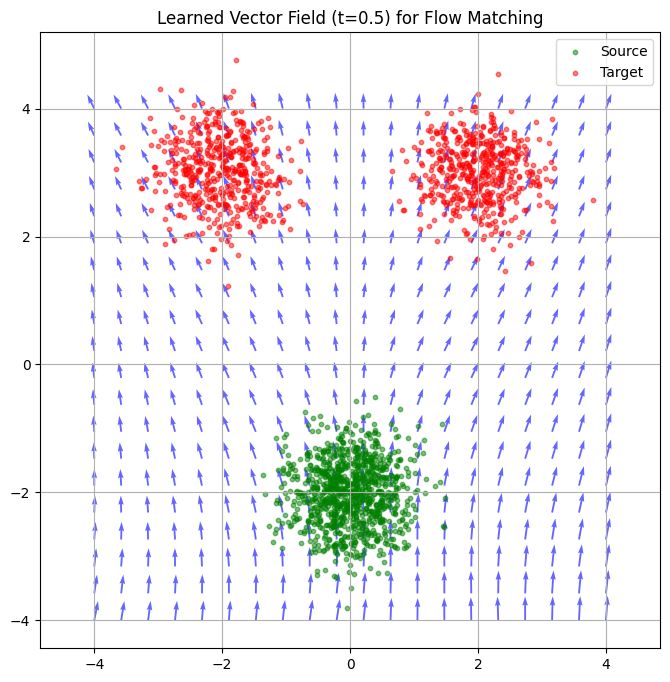

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

# Generate 2D source and target distributions
n_samples = 1000
source_np = np.random.randn(n_samples, 2) * 0.5 + np.array([0, -2])
target_np_1 = np.random.randn(int(n_samples/2), 2) * 0.5 + np.array([2, 3])
target_np_2 = np.random.randn(int(n_samples/2), 2) * 0.5 + np.array([-2, 3])
target_np = np.concatenate([target_np_1, target_np_2])

source = torch.tensor(source_np, dtype=torch.float32)
target = torch.tensor(target_np, dtype=torch.float32)
t = torch.rand(n_samples, 1)  # Random time steps

# Neural network for the vector field
class VectorField(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(3, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 2)
        )

    def forward(self, x, t):
        xt = torch.cat([x, t], dim=1)
        return self.net(xt)

# Train the model
model = VectorField()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

for epoch in tqdm(range(500), total = 500):
    optimizer.zero_grad()
    xt = source + t * (target - source)  # Interpolated points
    target_v = target - source
    pred_v = model(xt, t)
    loss = loss_fn(pred_v, target_v)
    loss.backward()
    optimizer.step()

# Evaluate vector field on a grid at t=0.5
grid_x, grid_y = torch.meshgrid(torch.linspace(-4, 4, 20), torch.linspace(-4, 4, 20), indexing="xy")
grid_points = torch.stack([grid_x.flatten(), grid_y.flatten()], dim=1)
grid_t = torch.ones((grid_points.shape[0], 1)) * 0.99

with torch.no_grad():
    grid_v = model(grid_points, grid_t).numpy()

# Plot vector field and samples
plt.figure(figsize=(8, 8))
plt.quiver(grid_points[:, 0], grid_points[:, 1], grid_v[:, 0], grid_v[:, 1], color='blue', alpha=0.6)
plt.scatter(source_np[:, 0], source_np[:, 1], color='green', s=10, alpha=0.5, label='Source')
plt.scatter(target_np[:, 0], target_np[:, 1], color='red', s=10, alpha=0.5, label='Target')
plt.legend()
plt.title("Learned Vector Field (t=0.5) for Flow Matching")
plt.axis('equal')
plt.grid(True)
plt.show()


In [ ]:
grid_points.shape

torch.Size([400, 2])

In [ ]:
grid_t = torch.ones((grid_points.shape[0], 1)) * 0.1

with torch.no_grad():
    grid_v2 = model(grid_points, grid_t).numpy()

grid_v2.shape

(400, 2)

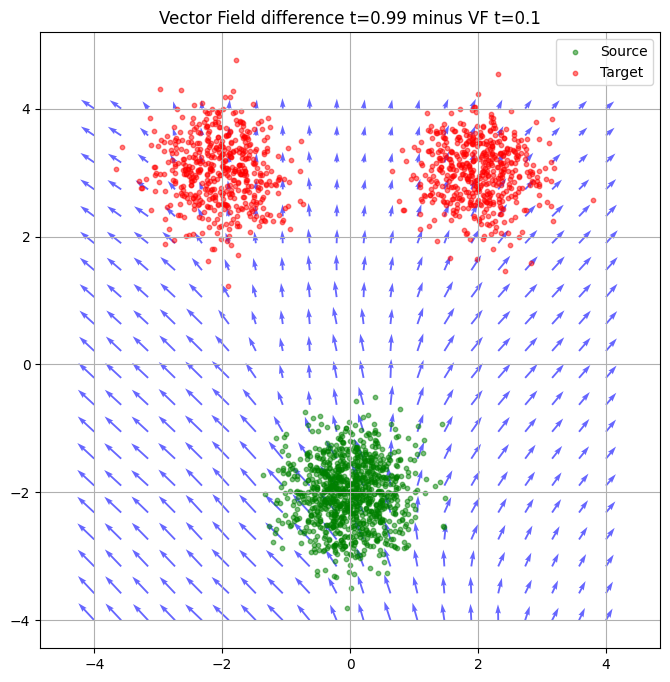

In [ ]:
grid_v_dif = grid_v - grid_v2

plt.figure(figsize=(8, 8))
plt.quiver(grid_points[:, 0], grid_points[:, 1], grid_v_dif[:, 0], grid_v_dif[:, 1], color='blue', alpha=0.6)
plt.scatter(source_np[:, 0], source_np[:, 1], color='green', s=10, alpha=0.5, label='Source')
plt.scatter(target_np[:, 0], target_np[:, 1], color='red', s=10, alpha=0.5, label='Target')
plt.legend()
plt.title("Vector Field difference t=0.99 minus VF t=0.1")
plt.axis('equal')
plt.grid(True)
plt.show()

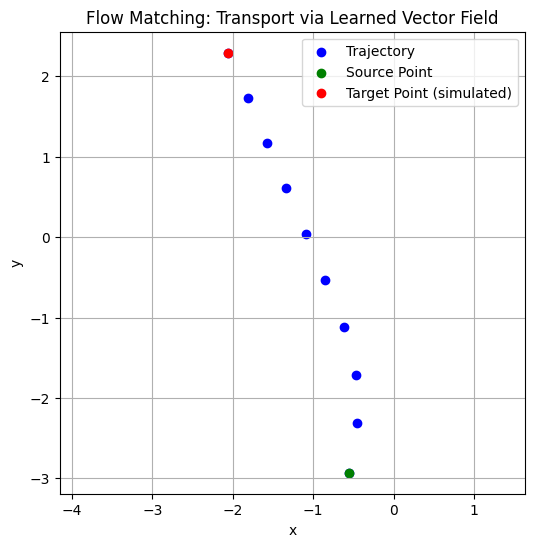

In [ ]:
from scipy.integrate import solve_ivp

# Function to evaluate vector field for ODE solver
def vector_field_ode(t, x_flat):
    x = torch.tensor(x_flat, dtype=torch.float32).unsqueeze(0)  # shape (1, 2)
    t_tensor = torch.tensor([[t]], dtype=torch.float32)  # shape (1, 1)
    with torch.no_grad():
        v = model(x, t_tensor)
    return v.numpy().flatten()

# Pick a random source sample
x0 = source_np[np.random.randint(0, len(source_np))]

# Solve ODE from t=0 to t=1
sol = solve_ivp(vector_field_ode, t_span=(0, 1), y0=x0, t_eval=np.linspace(0, 1, 10))

# Plot the path
plt.figure(figsize=(6, 6))
plt.scatter(sol.y[0], sol.y[1], label='Trajectory', color='blue')
plt.scatter(*x0, color='green', label='Source Point',)
plt.scatter(sol.y[0, -1], sol.y[1, -1], color='red', label='Target Point (simulated)')
plt.title("Flow Matching: Transport via Learned Vector Field")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.axis('equal')
plt.grid(True)
plt.show()


# Optimal Transport

Optimal Wasserstein-1 distance: 1.000
Optimal transport plan γ:
 [[ 0.5 -0. ]
 [ 0.   0.5]]


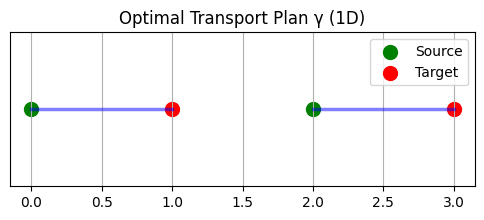

In [ ]:
import numpy as np
from scipy.optimize import linprog
import matplotlib.pyplot as plt

# 1D support and marginals
x = np.array([0, 2])
y = np.array([1, 3])
mu = np.array([0.5, 0.5])
nu = np.array([0.5, 0.5])

n = len(x)
m = len(y)

# Cost matrix: |x_i - y_j| (1D Wasserstein-1)
C = np.abs(x[:, None] - y[None, :])  # shape (n, m)

# Flatten cost for linprog objective
c = C.flatten()

# Constraints:
# - A_eq @ gamma = b_eq
# Each row: sum of transports from x_i equals mu_i
# Each column: sum of transports to y_j equals nu_j
A_eq = []

# Row constraints (source)
for i in range(n):
    row = np.zeros(n * m)
    row[i * m:(i + 1) * m] = 1
    A_eq.append(row)

# Column constraints (target)
for j in range(m):
    col = np.zeros(n * m)
    col[j::m] = 1
    A_eq.append(col)

A_eq = np.array(A_eq)
b_eq = np.concatenate([mu, nu])

# Bounds: gamma_ij ≥ 0
bounds = [(0, None)] * (n * m)

# Solve the linear program
res = linprog(c, A_eq=A_eq, b_eq=b_eq, bounds=bounds, method='highs')

if res.success:
    gamma_opt = res.x.reshape(n, m)
    wasserstein_1 = res.fun
    print(f"Optimal Wasserstein-1 distance: {wasserstein_1:.3f}")
    print("Optimal transport plan γ:\n", gamma_opt)
else:
    print("Linear program failed:", res.message)

# Visualize transport plan
plt.figure(figsize=(6, 2))
plt.scatter(x, np.zeros_like(x), color='green', label='Source', s=100)
plt.scatter(y, np.zeros_like(y), color='red', label='Target', s=100)

for i in range(n):
    for j in range(m):
        if gamma_opt[i, j] > 0:
            plt.plot([x[i], y[j]], [0, 0], linewidth=5 * gamma_opt[i, j], alpha=0.5, color='blue')

plt.title("Optimal Transport Plan γ (1D)")
plt.legend()
plt.grid(True)
plt.yticks([])
plt.show()


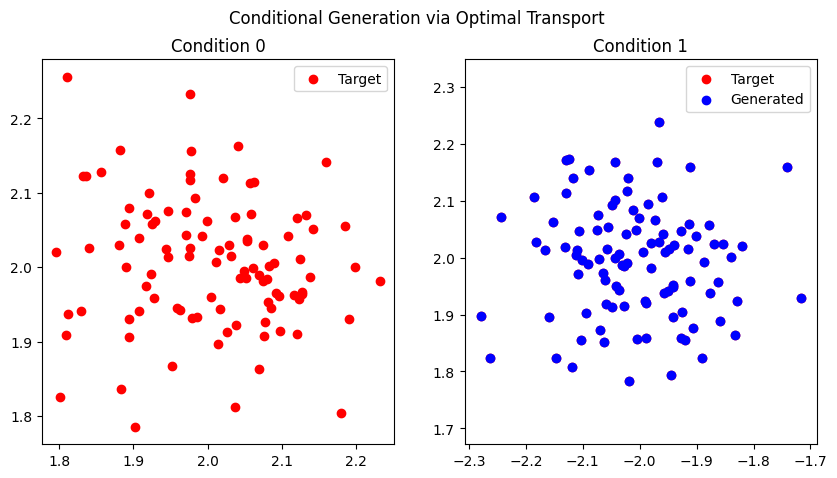

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import linprog

def generate_gaussian(n, mean, cov):
    return np.random.multivariate_normal(mean, cov, n)

def compute_ot_plan(source, target):
    n, m = len(source), len(target)

    # Cost matrix
    cost_matrix = np.linalg.norm(source[:, None] - target[None, :], axis=-1)
    c = cost_matrix.flatten()

    # Constraints
    A_eq = []
    for i in range(n):
        row = np.zeros(n * m)
        row[i * m:(i + 1) * m] = 1
        A_eq.append(row)
    for j in range(m):
        col = np.zeros(n * m)
        col[j::m] = 1
        A_eq.append(col)
    A_eq = np.array(A_eq)

    b_eq = np.concatenate([np.ones(n) / n, np.ones(m) / m])
    bounds = [(0, None)] * (n * m)

    res = linprog(c, A_eq=A_eq, b_eq=b_eq, bounds=bounds, method='highs')
    if res.success:
        return res.x.reshape(n, m)
    else:
        raise ValueError("OT LP failed.")

def barycentric_projection(source, target, gamma):
    # γ[i,j]: mass from source[i] to target[j]
    weights = gamma / gamma.sum(axis=1, keepdims=True)
    return weights @ target

# Generate conditional data
n = 100
x0 = generate_gaussian(n, mean=[0, 0], cov=0.01 * np.eye(2))     # base for c=0
y0 = generate_gaussian(n, mean=[2, 2], cov=0.01 * np.eye(2))     # target for c=0

x1 = generate_gaussian(n, mean=[0, 0], cov=0.01 * np.eye(2))     # base for c=1
y1 = generate_gaussian(n, mean=[-2, 2], cov=0.01 * np.eye(2))    # target for c=1

# Compute OT plans and maps
gamma0 = compute_ot_plan(x0, y0)
gamma1 = compute_ot_plan(x1, y1)

T0 = barycentric_projection(x0, y0, gamma0)
T1 = barycentric_projection(x1, y1, gamma1)

# Define conditional generator
def conditional_generator(z, condition):
    if condition == 0:
        return barycentric_projection(z, y0, compute_ot_plan(z, y0))
    else:
        return barycentric_projection(z, y1, compute_ot_plan(z, y1))

# Sample and generate
z_sample = generate_gaussian(100, [0, 0], 0.01 * np.eye(2))
x_gen_0 = conditional_generator(z_sample, condition=0)
x_gen_1 = conditional_generator(z_sample, condition=1)

# Visualize
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("Condition 0")
plt.scatter(y0[:, 0], y0[:, 1], color='red', label='Target')
#plt.scatter(x_gen_0[:, 0], x_gen_0[:, 1], color='blue', label='Generated')
plt.legend()
plt.axis('equal')

plt.subplot(1, 2, 2)
plt.title("Condition 1")
plt.scatter(y1[:, 0], y1[:, 1], color='red', label='Target')
plt.scatter(x_gen_1[:, 0], x_gen_1[:, 1], color='blue', label='Generated')
plt.legend()
plt.axis('equal')

plt.suptitle("Conditional Generation via Optimal Transport")
plt.show()
